In [1]:
from pandas import DataFrame, read_csv
from matplotlib.pyplot import subplots, show
from libs.ds_charts import choose_grid, plot_clusters, plot_line, compute_mse, compute_centroids
from numpy import arange, ndarray
from statistics import variance
import numpy as np


In [2]:
def compute_mae(X: ndarray, labels: list, centroids: list) -> float:
    n = len(X)
    centroid_per_record = [centroids[labels[i]] for i in range(n)]
    partial = X - centroid_per_record
    partial = list(partial * partial)
    partial = [sum(el) for el in partial]
    partial = sum(partial)
    return partial / (n-1)

### Before PCA:

In [4]:
data: DataFrame = read_csv('data/pca/air_quality_scalled_pca.csv')
#data.pop('ALARM')

N_CLUSTERS = [2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
rows, cols = choose_grid(len(N_CLUSTERS))
data = data.sample(10000)
## variance of every variable
#lista = dict()
#for c in data.columns:
#    lista[c] = np.var(data[c])
#items = [*lista.values()]
#keys = [*lista.keys()]
#print(keys)
#print(keys.index("O3_Std"))
#print(keys.index("SO2_Min"))
#print(keys[np.argmax(items)])
#v1=keys[np.argmax(items)]
#remove = keys[np.argmax(lista)]

#lista.pop(remove)
#items = [*lista.values()]
#keys = [*lista.keys()]
#print(keys[np.argmax(items)])
#v2=keys[np.argmax(items)]
v1 = 12
v2 = 22


In [9]:
data = data.sample(10000)

### K-Means

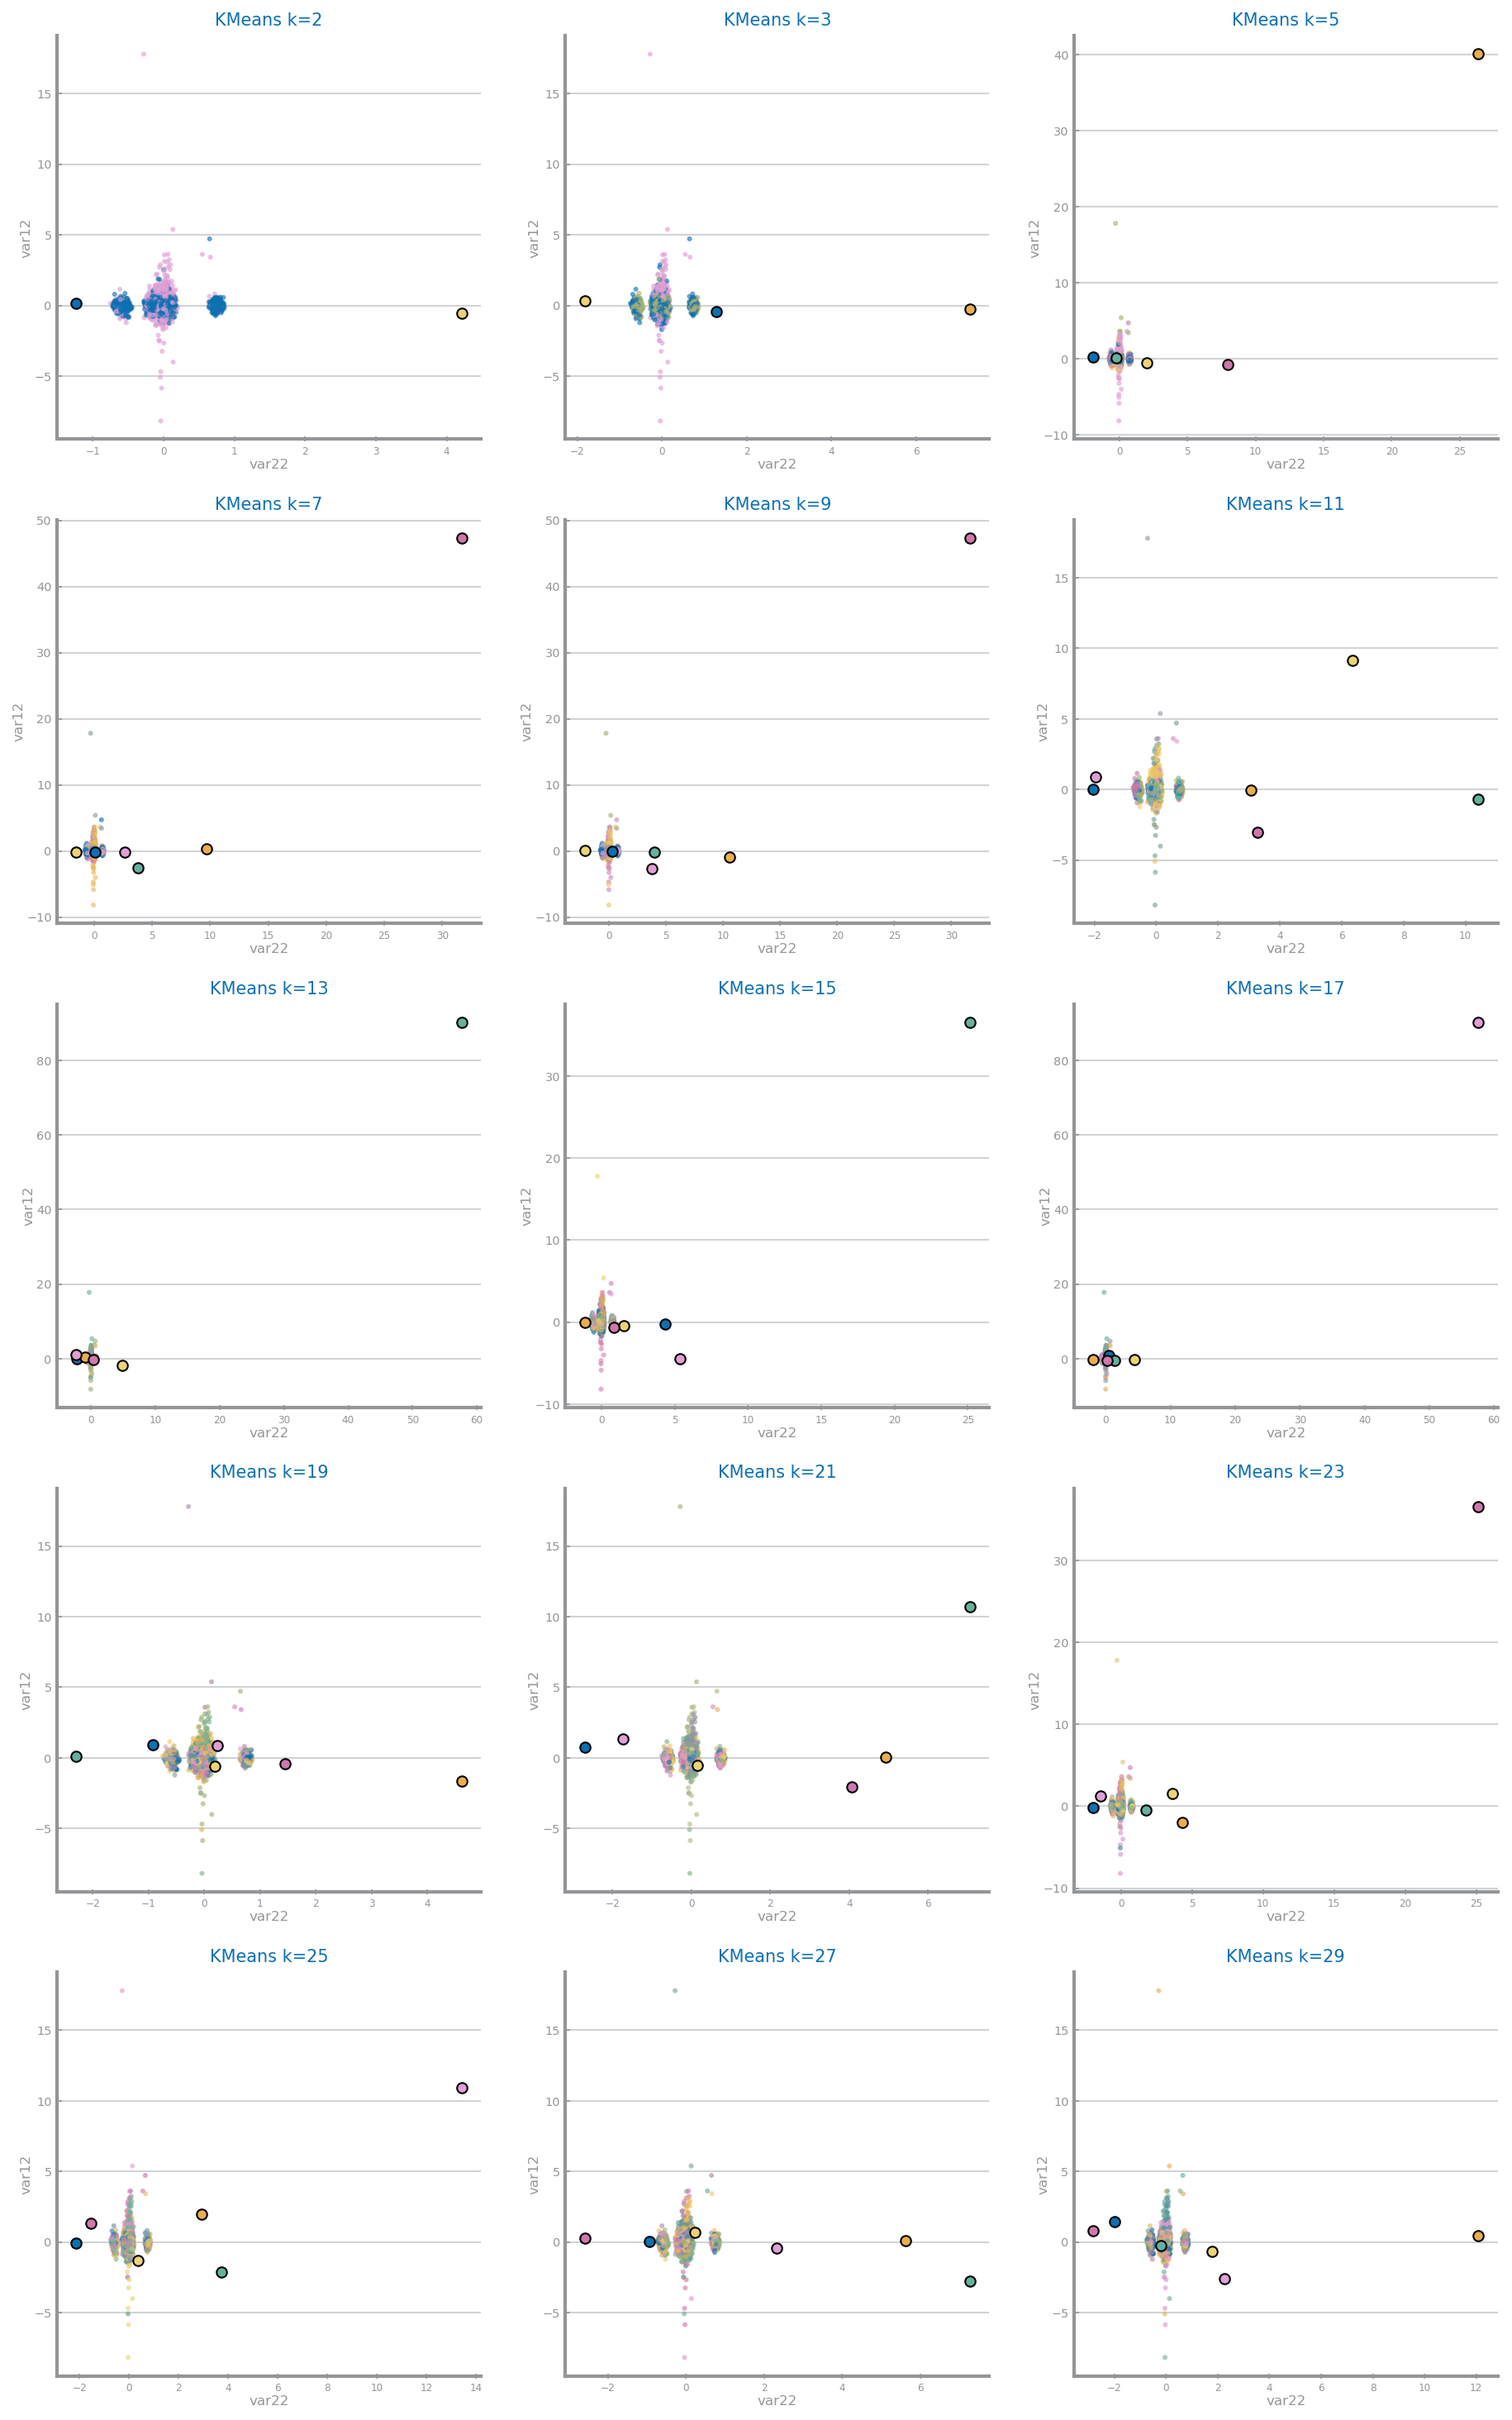

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from math import sqrt

mse: list = []
sc: list = []
mae: list = []
db: list = []
fig, axs = subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = KMeans(n_clusters=k)
    estimator.fit(data)
    labels = estimator.predict(data)
    mse.append(compute_mse(data.values, labels, estimator.cluster_centers_))
    mae.append(compute_mae(data.values, labels, estimator.cluster_centers_))
    sc.append(silhouette_score(data, estimator.labels_))
    db.append(davies_bouldin_score(data,estimator.labels_))
    plot_clusters(data, v2, v1, estimator.labels_.astype(float), estimator.cluster_centers_, k, f'KMeans k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
show()

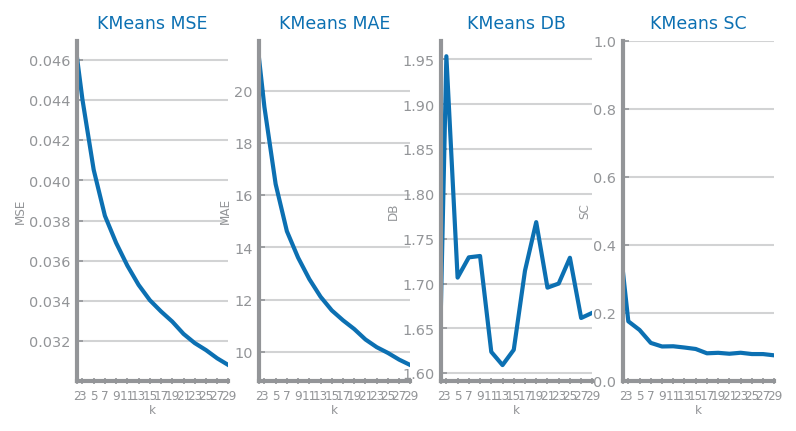

In [7]:
fig, ax = subplots(1, 4, figsize=(6, 3), squeeze=False)
plot_line(N_CLUSTERS, mse, title='KMeans MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
plot_line(N_CLUSTERS, mae, title='KMeans MAE', xlabel='k', ylabel='MAE', ax=ax[0, 1])
plot_line(N_CLUSTERS, db, title='KMeans DB', xlabel='k', ylabel='DB', ax=ax[0, 2])
plot_line(N_CLUSTERS, sc, title='KMeans SC', xlabel='k', ylabel='SC', ax=ax[0, 3], percentage=True)
show()

### EM

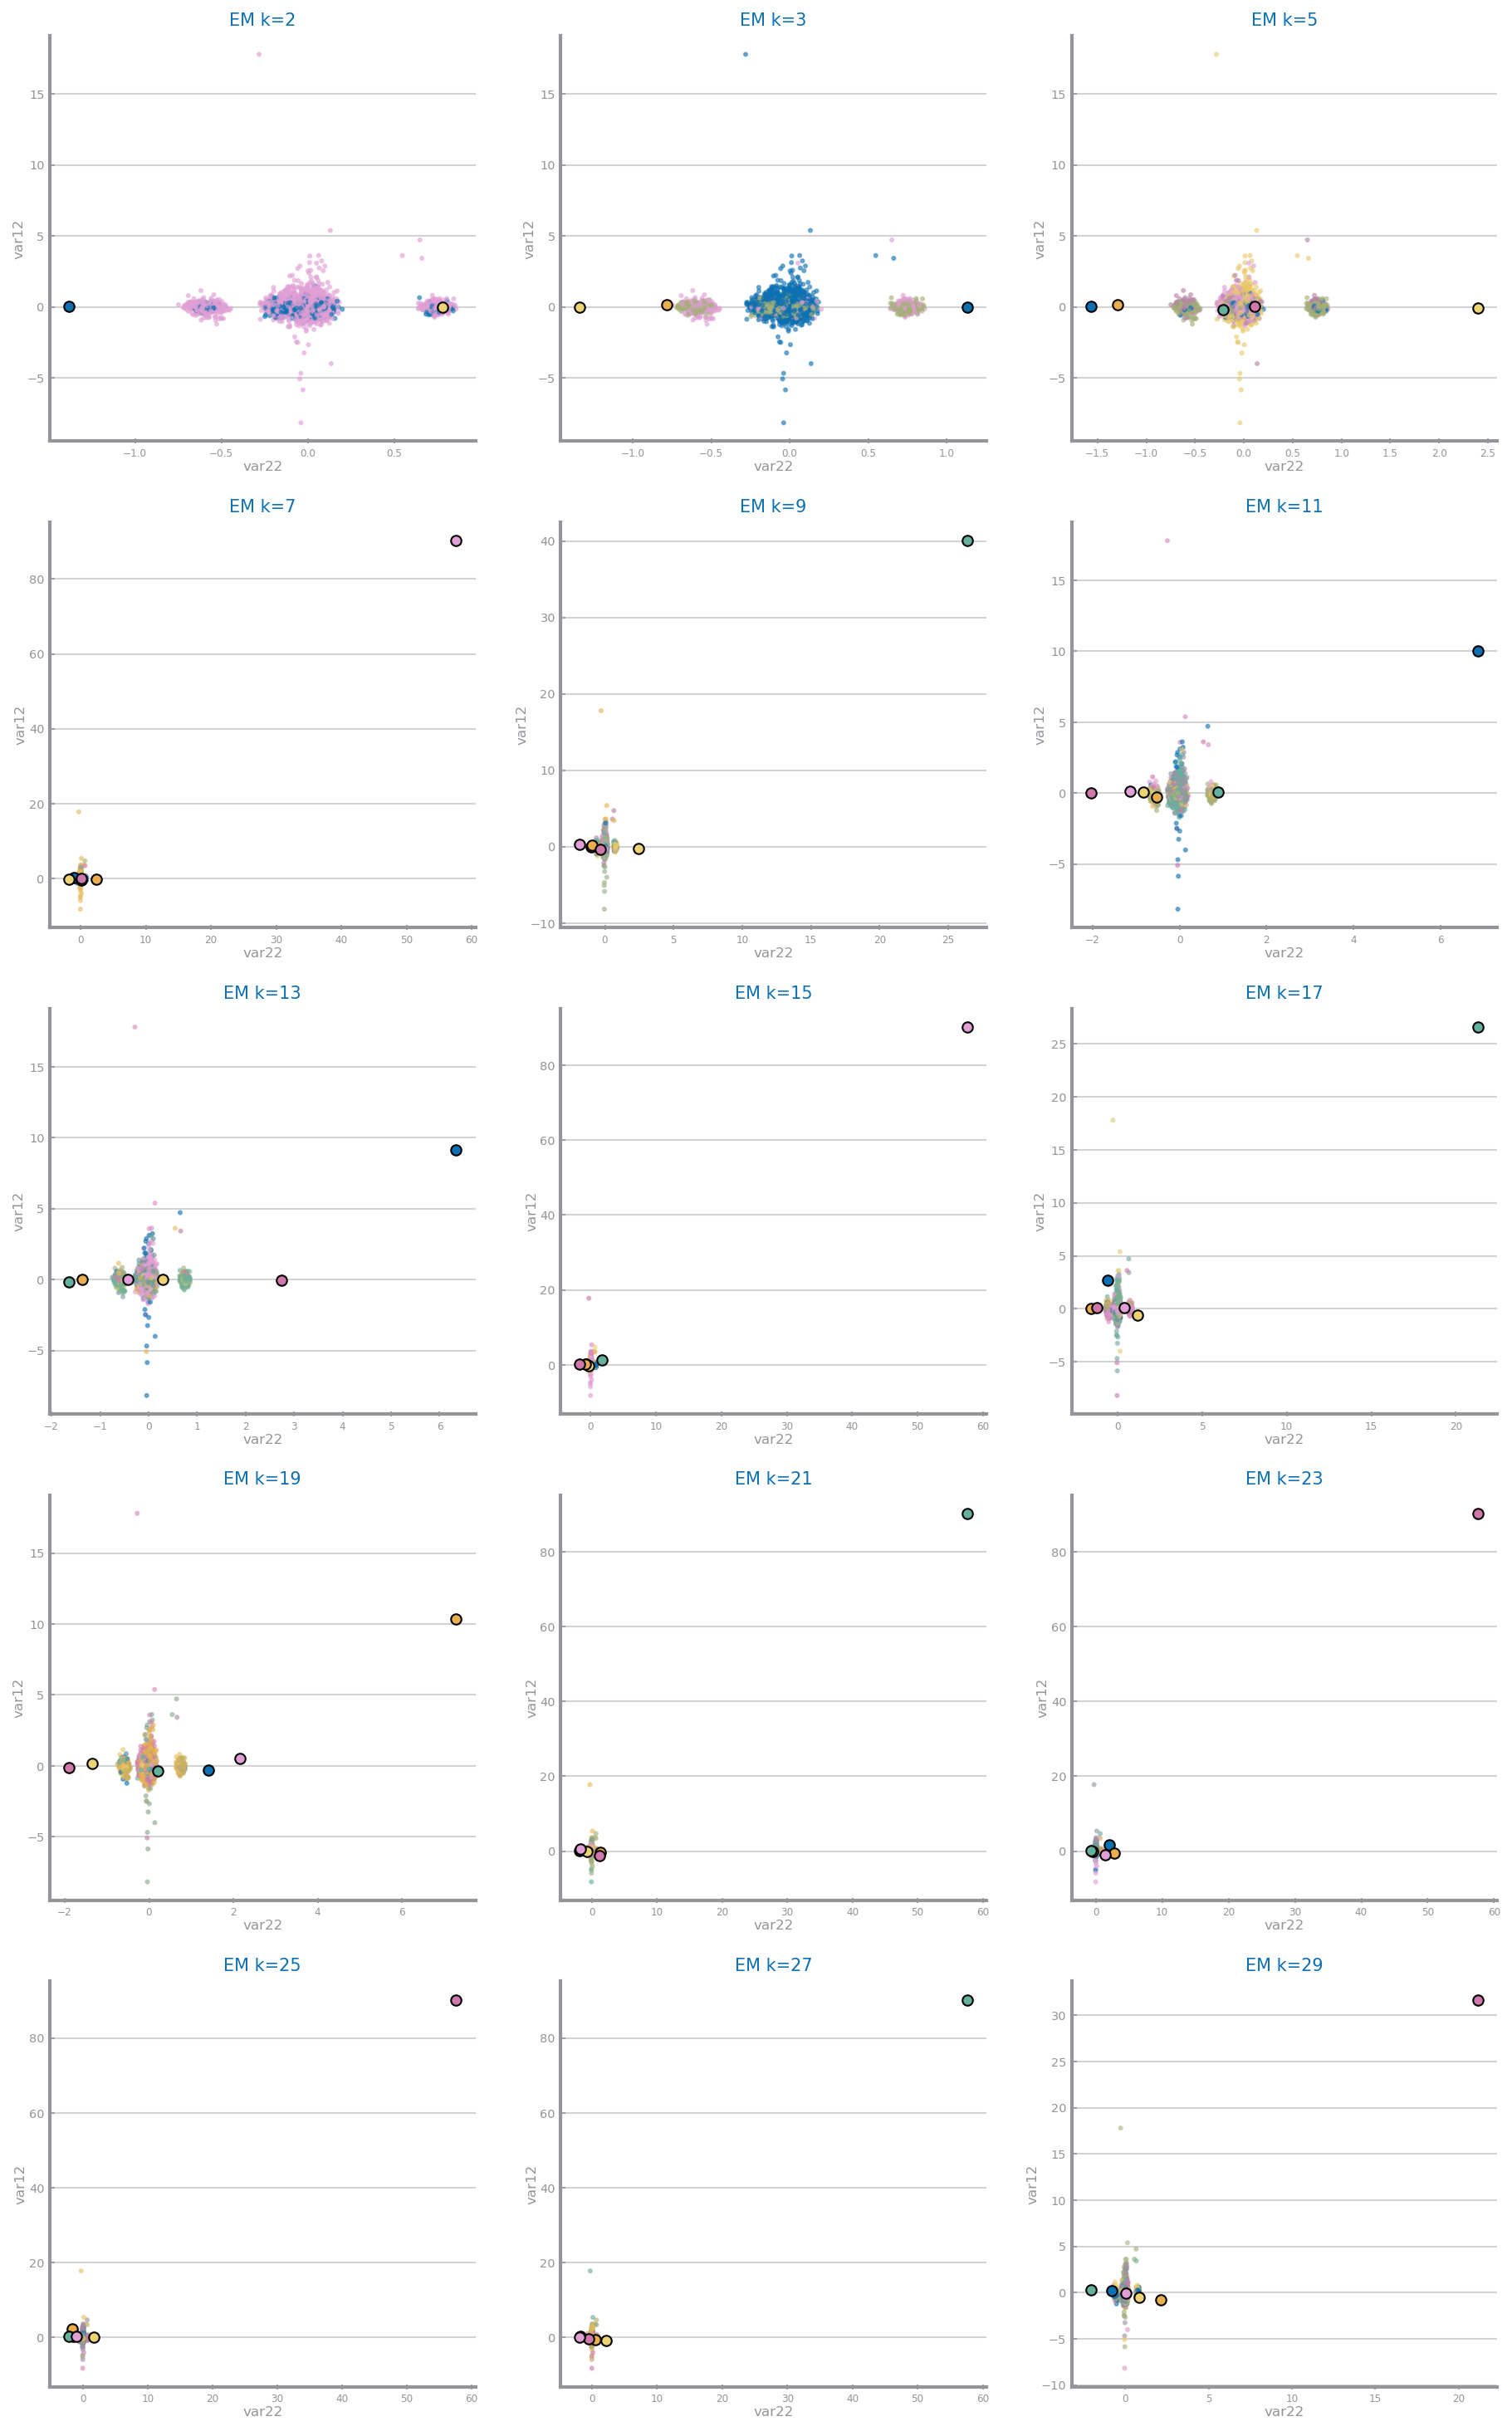

In [8]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

mse: list = []
sc: list = []
mae: list = []
db: list = []
_, axs = subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = GaussianMixture(n_components=k)
    estimator.fit(data)
    labels = estimator.predict(data)
    mse.append(compute_mse(data.values, labels, estimator.means_))
    sc.append(silhouette_score(data, labels))
    db.append(davies_bouldin_score(data,labels))
    mae.append(compute_mae(data.values, labels, estimator.means_))
    plot_clusters(data, v2, v1, labels.astype(float), estimator.means_, k,
                     f'EM k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
show()

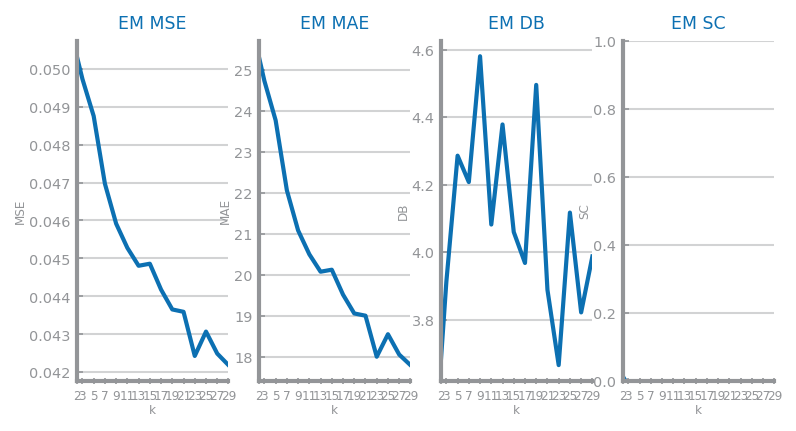

In [9]:
fig, ax = subplots(1, 4, figsize=(6, 3), squeeze=False)
plot_line(N_CLUSTERS, mse, title='EM MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
plot_line(N_CLUSTERS, mae, title='EM MAE', xlabel='k', ylabel='MAE', ax=ax[0, 1])
plot_line(N_CLUSTERS, db, title='EM DB', xlabel='k', ylabel='DB', ax=ax[0, 2])
plot_line(N_CLUSTERS, sc, title='EM SC', xlabel='k', ylabel='SC', ax=ax[0, 3], percentage=True)
show()

### DBSCAN

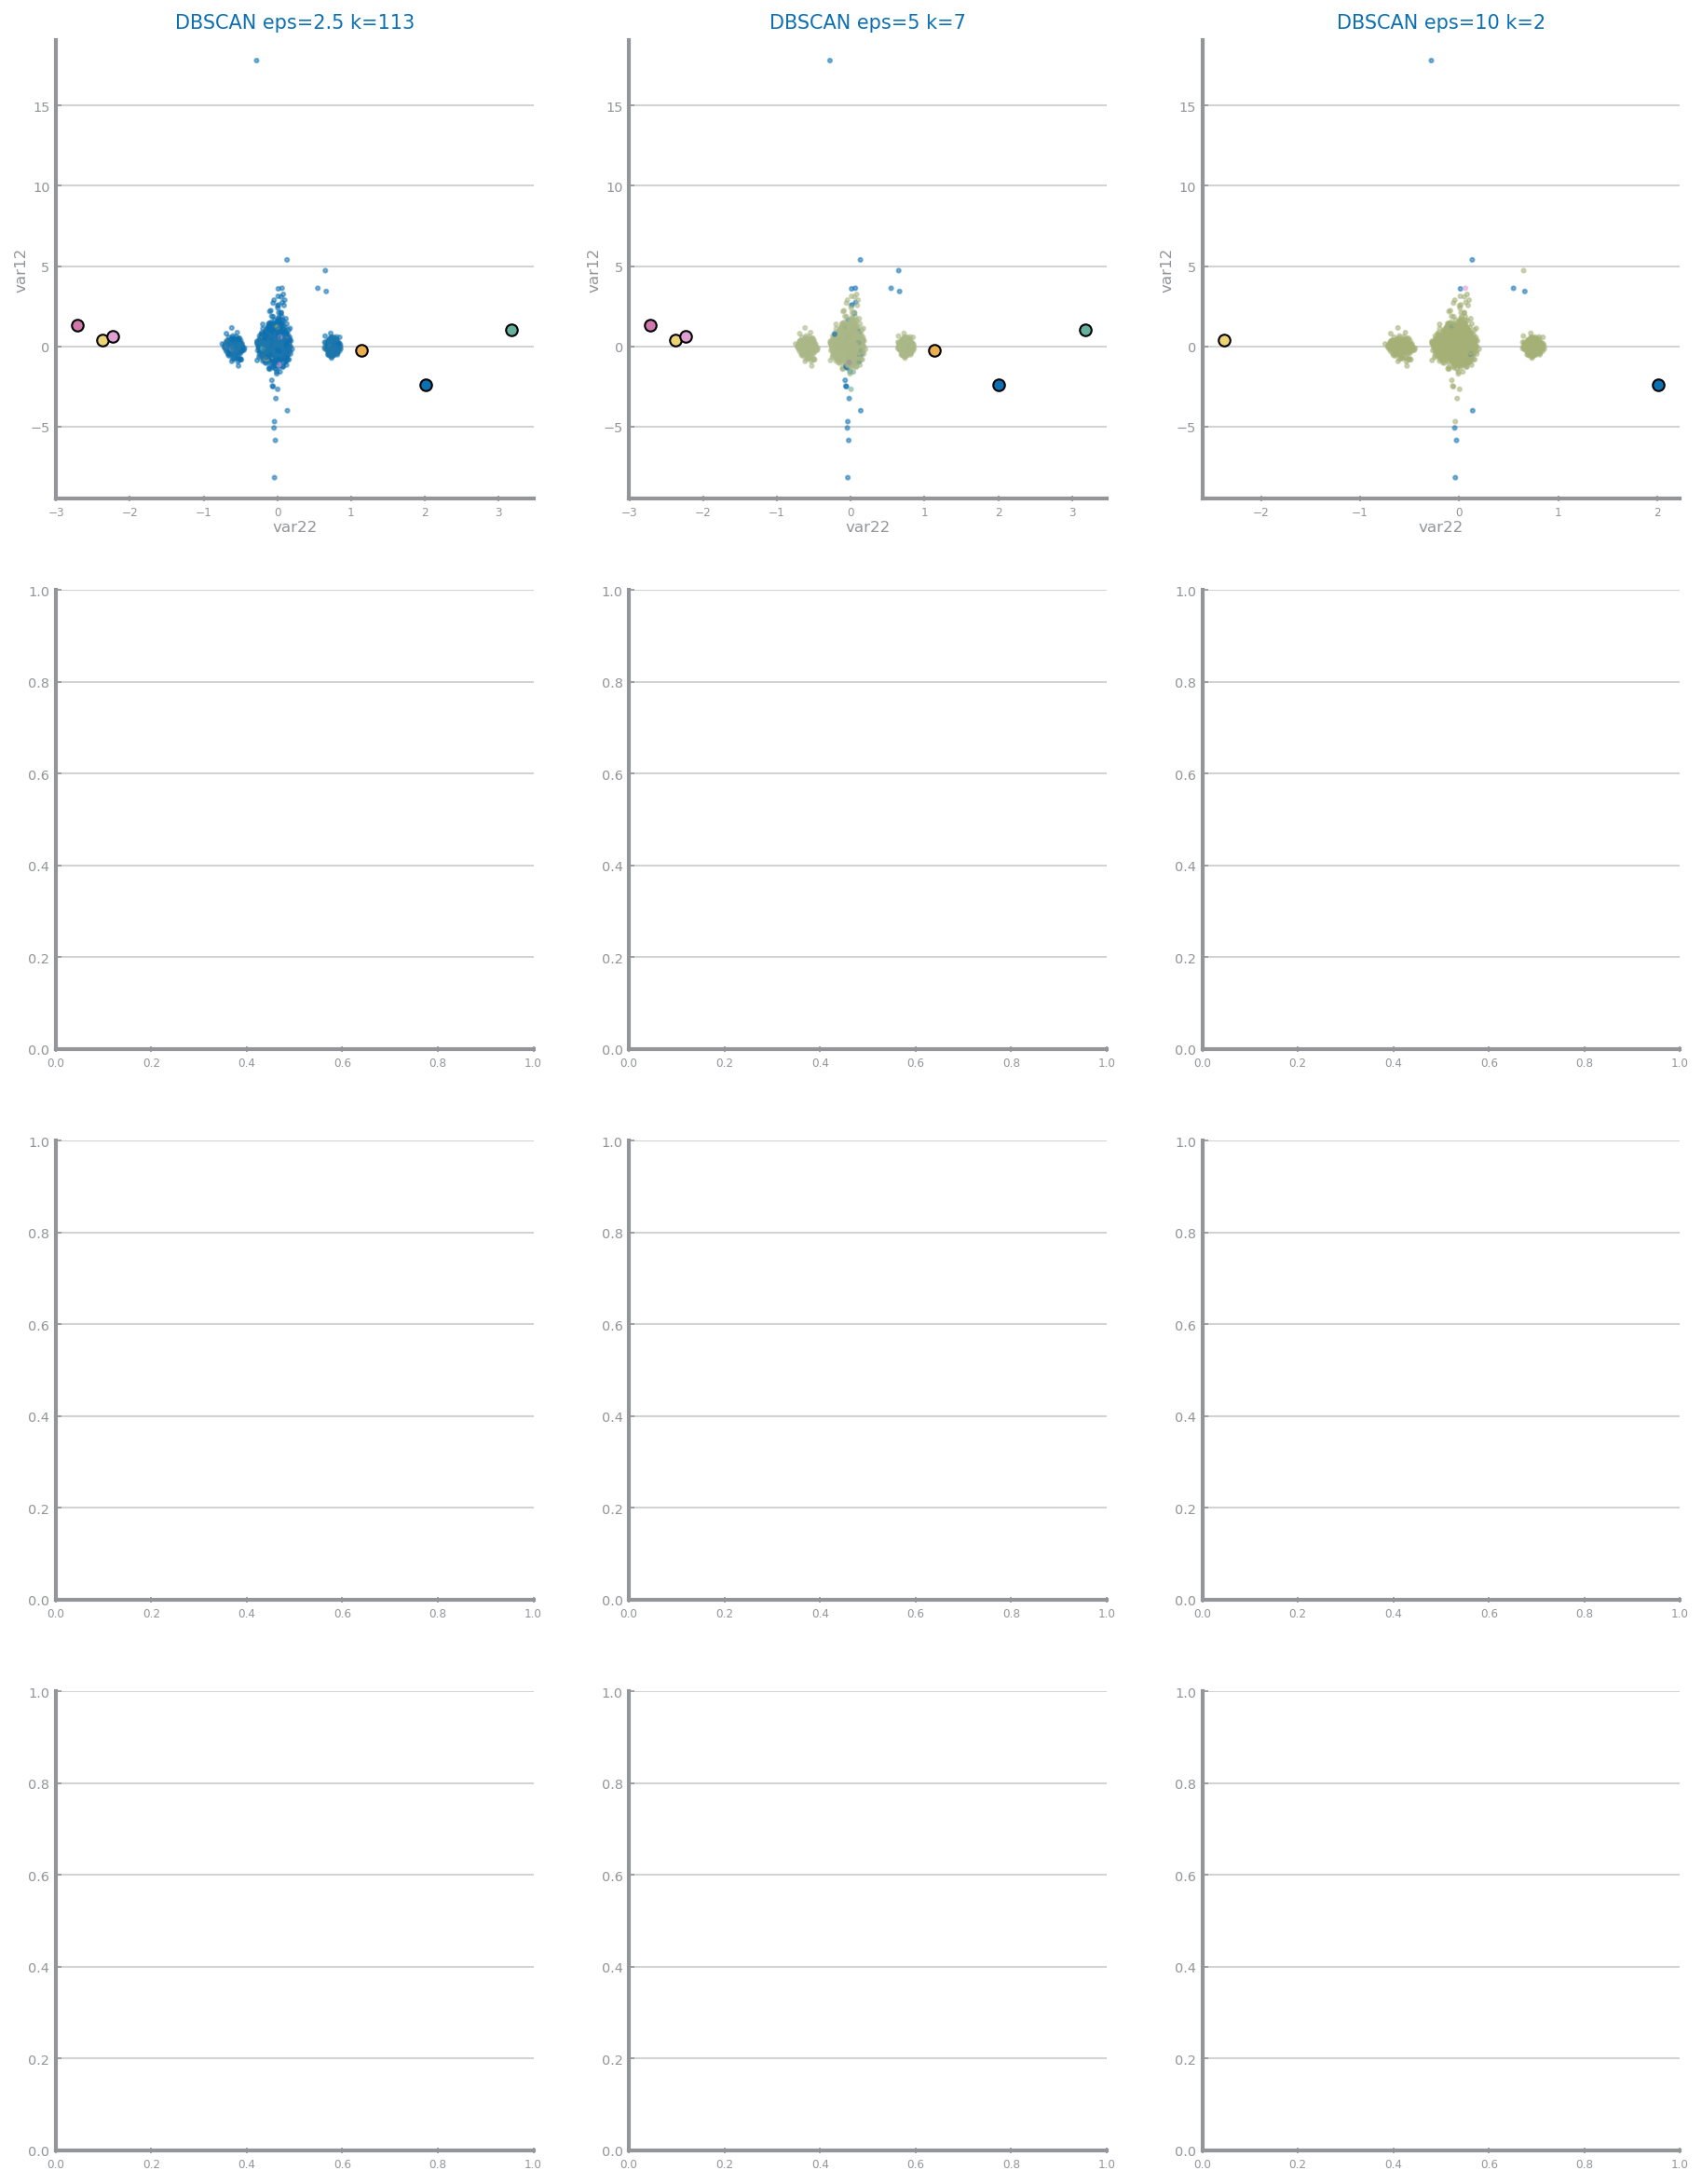

In [10]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

EPS = [2.5, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
mse: list = []
sc: list = []
mae: list = []
db: list = []
rows, cols = choose_grid(len(EPS))
_, axs = subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(EPS)):
    estimator = DBSCAN(eps=EPS[n], min_samples=2)
    estimator.fit(data)
    labels = estimator.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = compute_centroids(data, labels)
        mse.append(compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data,labels))
        mae.append(compute_mae(data.values, labels, centers))
        plot_clusters(data, v2, v1, labels.astype(float), estimator.components_, k, f'DBSCAN eps={EPS[n]} k={k}', ax=axs[i,j])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
        mae.append(0)
show()

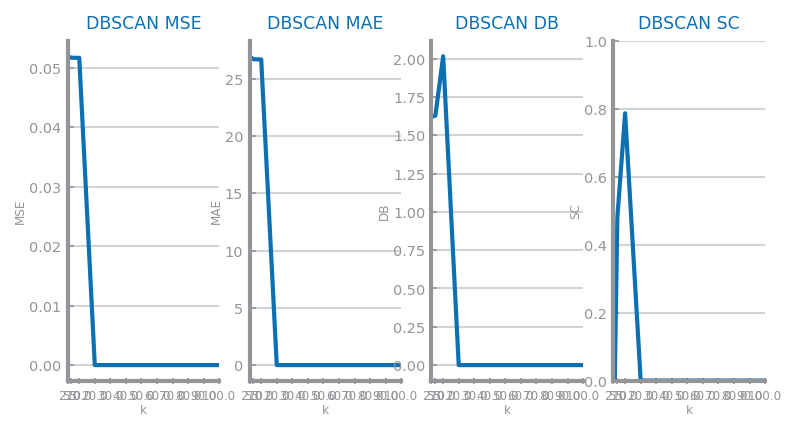

In [11]:
fig, ax = subplots(1, 4, figsize=(6, 3), squeeze=False)
plot_line(EPS, mse, title='DBSCAN MSE', xlabel='k', ylabel='MSE', ax=ax[0, 0])
plot_line(EPS, mae, title='DBSCAN MAE', xlabel='k', ylabel='MAE', ax=ax[0, 1])
plot_line(EPS, db, title='DBSCAN DB', xlabel='k', ylabel='DB', ax=ax[0, 2])
plot_line(EPS, sc, title='DBSCAN SC', xlabel='k', ylabel='SC', ax=ax[0, 3], percentage=True)
show()

In [16]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
distances = []
for m in METRICS:
    dist = np.mean(np.mean(squareform(pdist(data.values, metric=m))))
    distances.append(dist)

print('AVG distances among records', distances)
distances[0] *= 0.6
distances[1] = 80
distances[2] *= 0.6
distances[3] *= 0.1
distances[4] *= 0.15
print('CHOSEN EPS', distances)

AVG distances among records [6.191972488143152, 24.770673943576995, 3.911982123208757, 0.9719415195054085, 0.9974929799999998]
CHOSEN EPS [3.7151834928858913, 80, 2.3471892739252542, 0.09719415195054086, 0.14962394699999995]


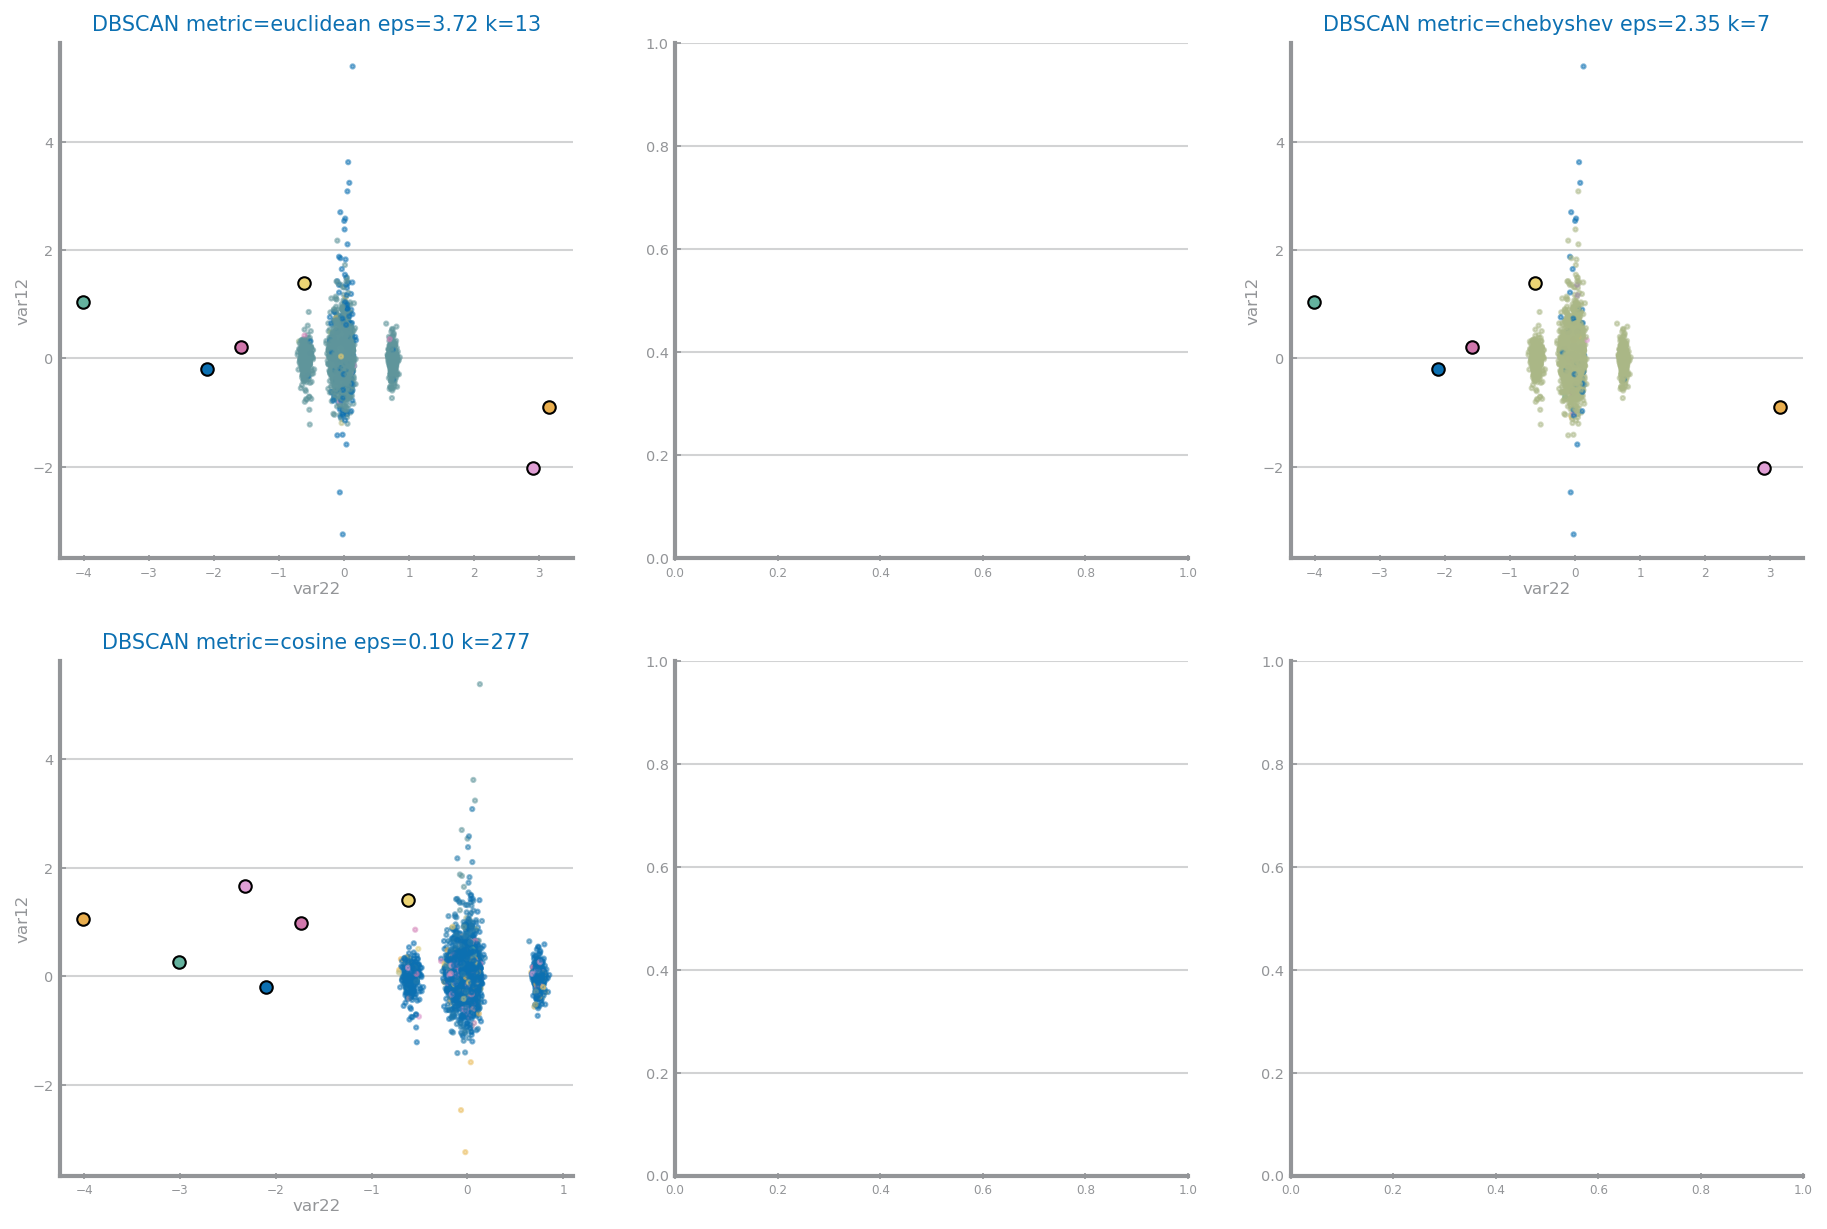

In [19]:
mse: list = []
sc: list = []
mae: list = []
db: list = []
rows, cols = choose_grid(len(METRICS))
_, axs = subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(METRICS)):
    estimator = DBSCAN(eps=distances[n], min_samples=2, metric=METRICS[n])
    estimator.fit(data)
    labels = estimator.labels_
    k = len(set(labels)) - (1 if -1 in labels else 0)
    if k > 1:
        centers = compute_centroids(data, labels)
        mse.append(compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data,labels))
        mae.append(compute_mae(data.values, labels, centers))
        plot_clusters(data, v2, v1, labels.astype(float), estimator.components_, k, f'DBSCAN metric={METRICS[n]} eps={distances[n]:.2f} k={k}', ax=axs[i,j])
    else:
        mse.append(0)
        sc.append(0)
        db.append(0)
        mae.append(0)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
show()

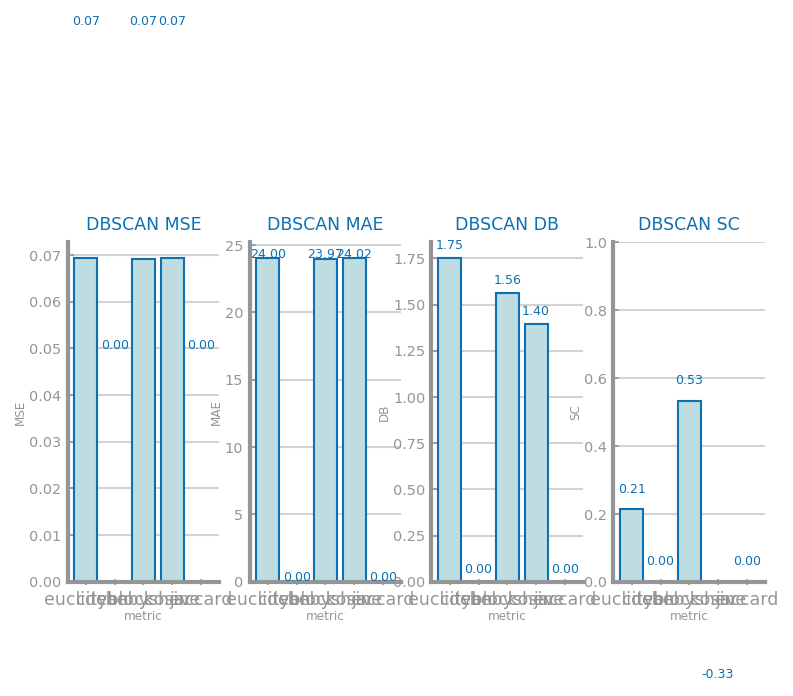

In [20]:
from libs.ds_charts import bar_chart
fig, ax = subplots(1, 4, figsize=(6, 3), squeeze=False)
bar_chart(METRICS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
bar_chart(METRICS, mae, title='DBSCAN MAE', xlabel='metric', ylabel='MAE', ax=ax[0, 1])
bar_chart(METRICS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB', ax=ax[0, 2])
bar_chart(METRICS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 3], percentage=True)
show()

### Hierarchical

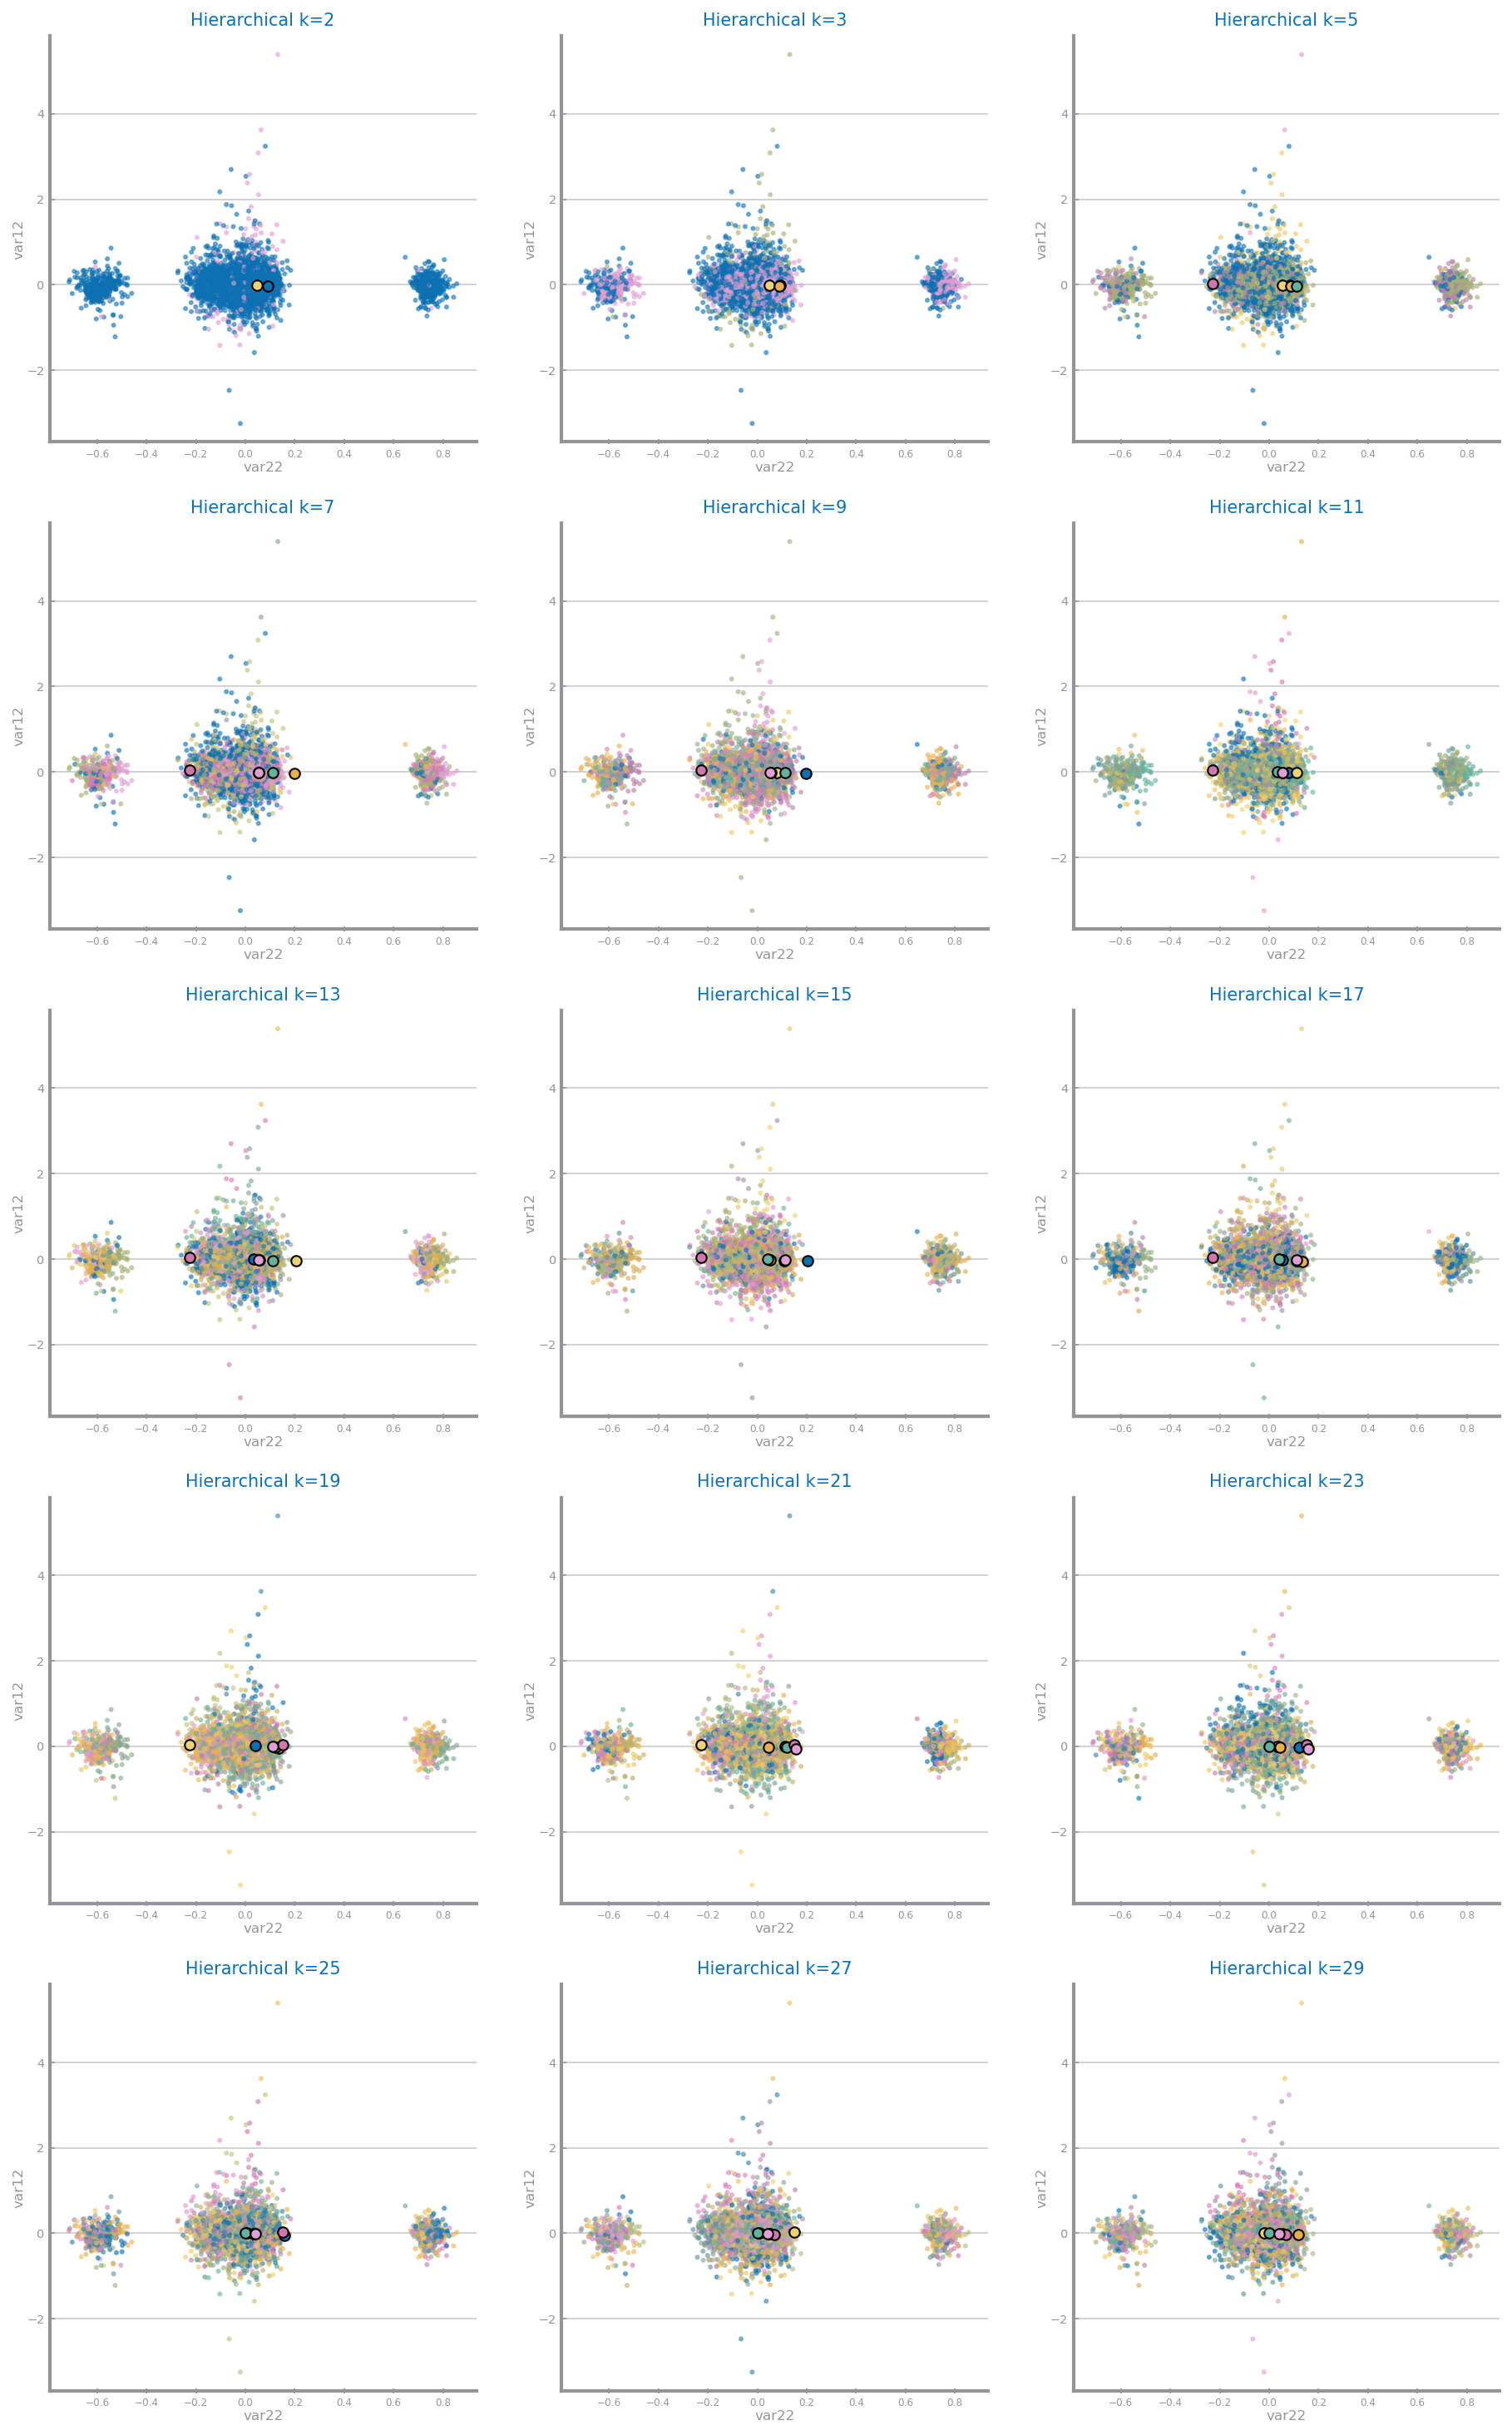

In [12]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

data = data.sample(5000)
mse: list = []
sc: list = []
mae: list = []
db: list = []
rows, cols = choose_grid(len(N_CLUSTERS))
_, axs = subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
i, j = 0, 0
for n in range(len(N_CLUSTERS)):
    k = N_CLUSTERS[n]
    estimator = AgglomerativeClustering(n_clusters=k)
    estimator.fit(data)
    labels = estimator.labels_
    centers = compute_centroids(data, labels)
    mse.append(compute_mse(data.values, labels, centers))
    sc.append(silhouette_score(data, labels))
    db.append(davies_bouldin_score(data,labels))
    mae.append(compute_mae(data.values, labels, centers))
    plot_clusters(data, v2, v1, labels, centers, k, f'Hierarchical k={k}', ax=axs[i,j])
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
show()

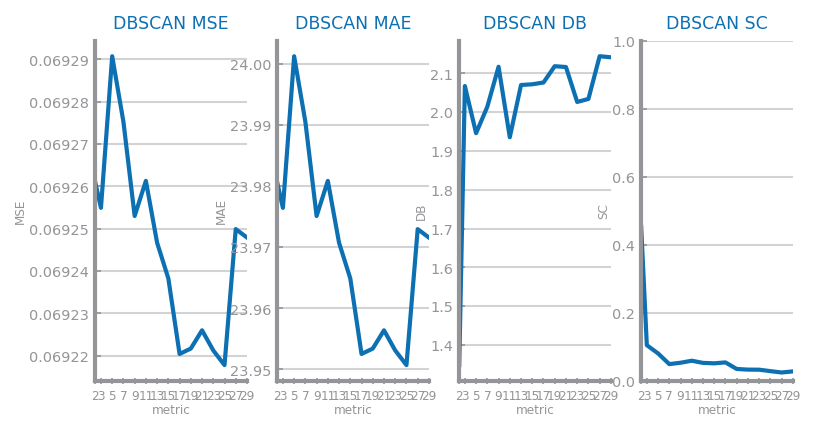

In [13]:
from libs.ds_charts import bar_chart
fig, ax = subplots(1, 4, figsize=(6, 3), squeeze=False)
plot_line(N_CLUSTERS, mse, title='DBSCAN MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
plot_line(N_CLUSTERS, mae, title='DBSCAN MAE', xlabel='metric', ylabel='MAE', ax=ax[0, 1])
plot_line(N_CLUSTERS, db, title='DBSCAN DB', xlabel='metric', ylabel='DB', ax=ax[0, 2])
plot_line(N_CLUSTERS, sc, title='DBSCAN SC', xlabel='metric', ylabel='SC', ax=ax[0, 3], percentage=True)
show()

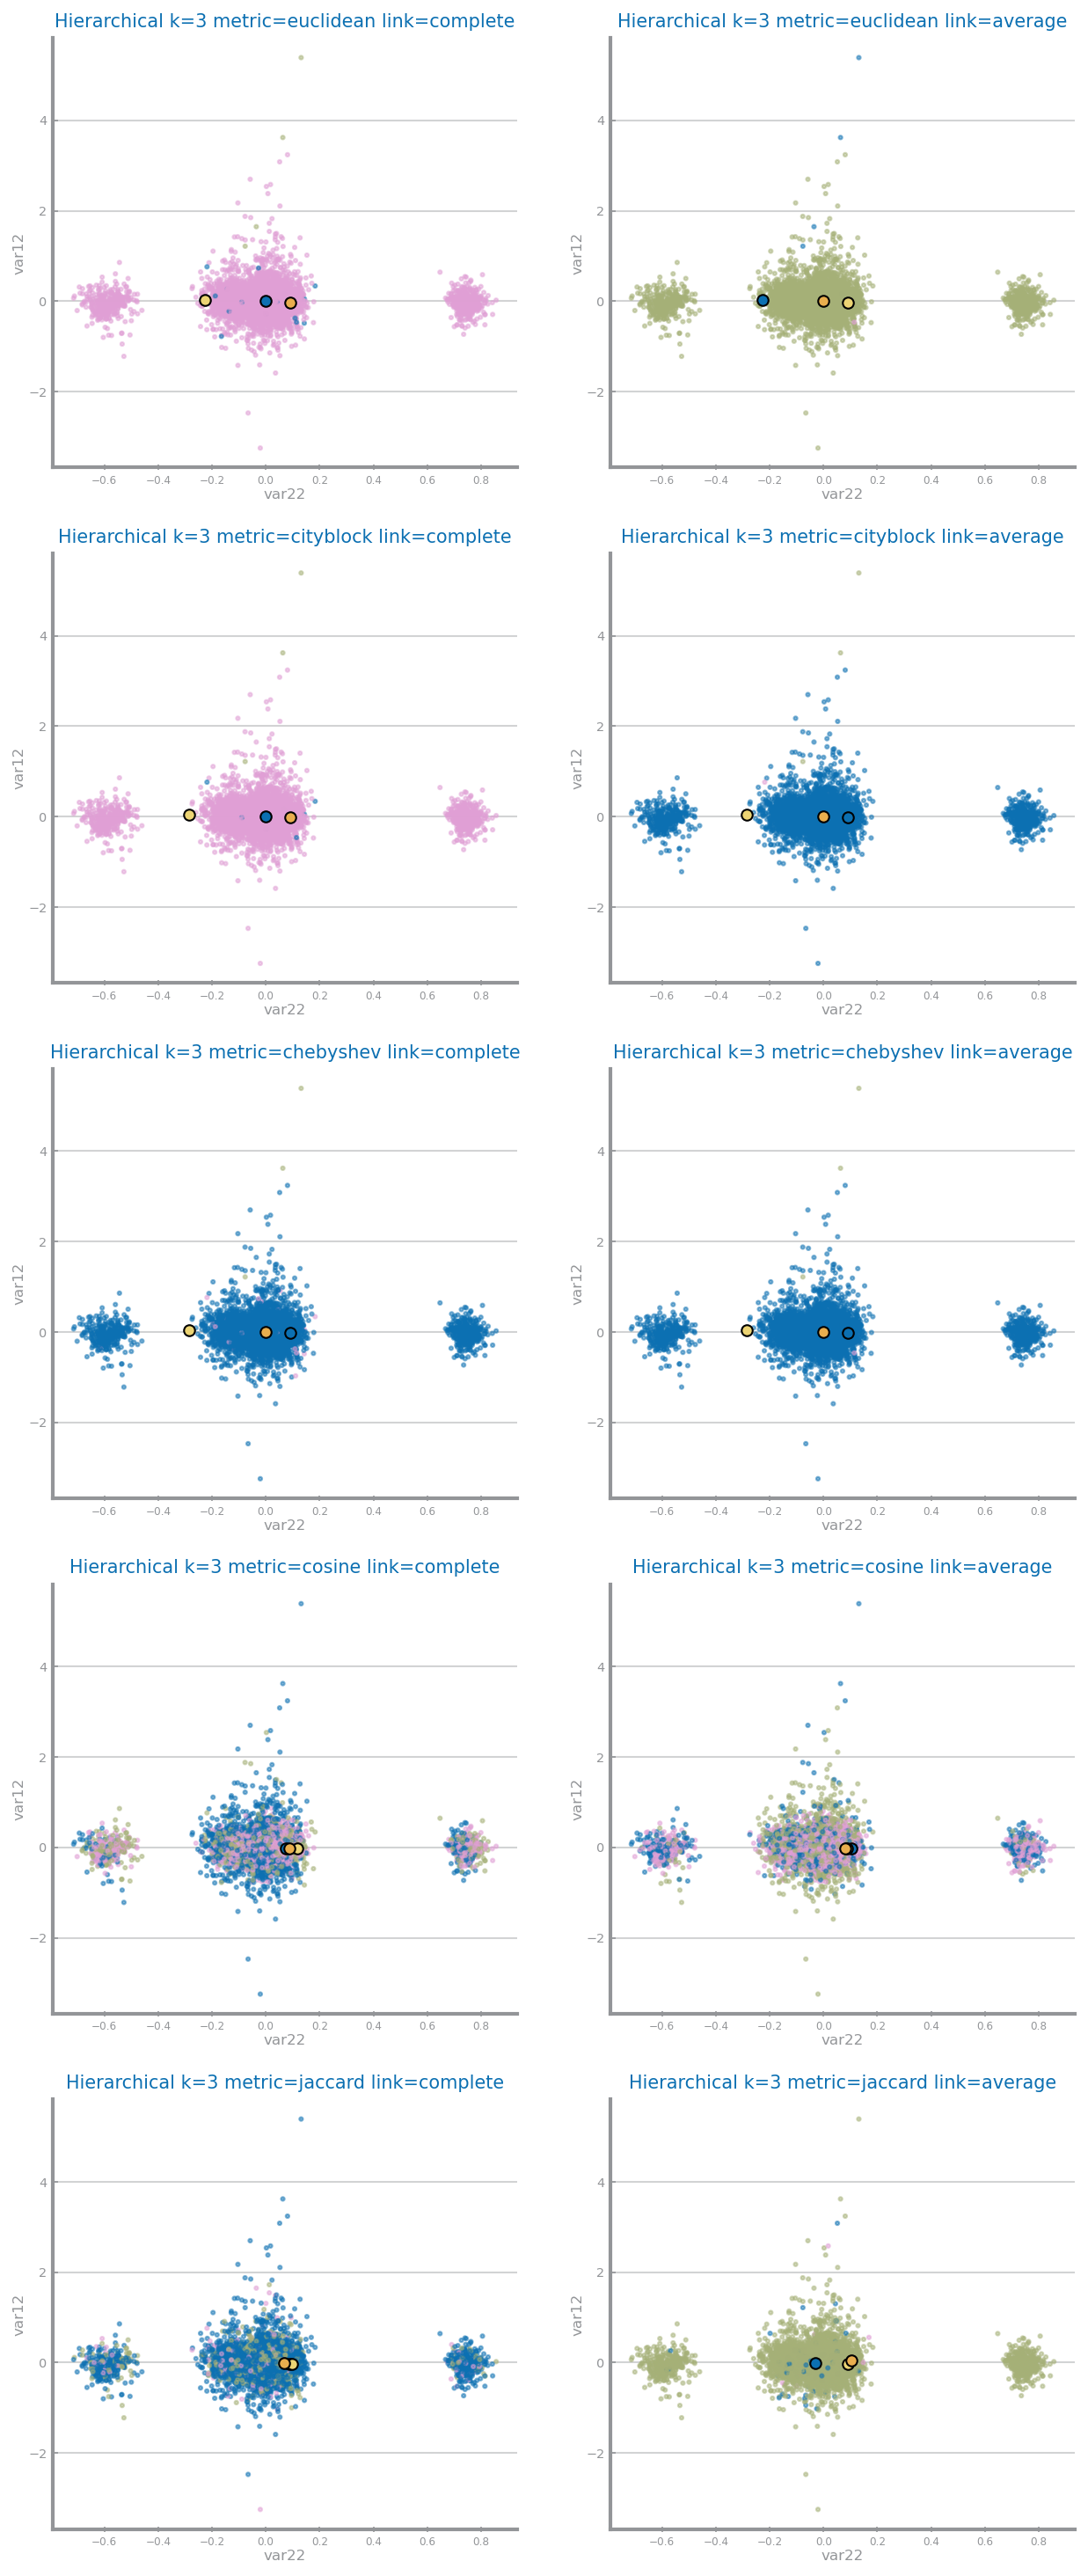

In [14]:
METRICS = ['euclidean', 'cityblock', 'chebyshev', 'cosine', 'jaccard']
LINKS = ['complete', 'average']
k = 3
values_mse = {}
values_sc = {}
values_mae ={}
values_db = {}
rows = len(METRICS)
cols = len(LINKS)
_, axs = subplots(rows, cols, figsize=(cols*5, rows*5), squeeze=False)
for i in range(len(METRICS)):
    mse: list = []
    sc: list = []
    mae: list = []
    db: list = []
    m = METRICS[i]
    for j in range(len(LINKS)):
        link = LINKS[j]
        estimator = AgglomerativeClustering(n_clusters=k, linkage=link, affinity=m )
        estimator.fit(data)
        labels = estimator.labels_
        centers = compute_centroids(data, labels)
        mse.append(compute_mse(data.values, labels, centers))
        sc.append(silhouette_score(data, labels))
        db.append(davies_bouldin_score(data,labels))
        mae.append(compute_mae(data.values, labels, centers))
        plot_clusters(data, v2, v1, labels, centers, k, f'Hierarchical k={k} metric={m} link={link}', ax=axs[i,j])
    values_mse[m] = mse
    values_sc[m] = sc
    values_mae[m] = mae
    values_db[m] = db
show()

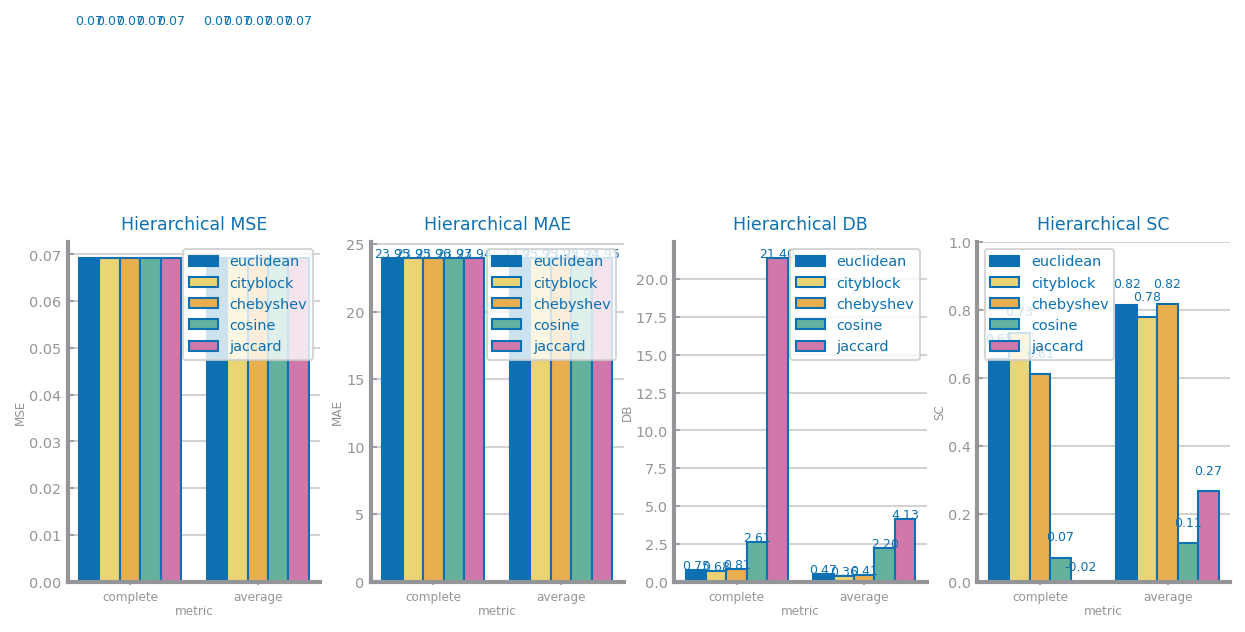

In [15]:
from libs.ds_charts import multiple_bar_chart
_, ax = subplots(1, 4, figsize=(10, 3), squeeze=False)
multiple_bar_chart(LINKS, values_mse, title=f'Hierarchical MSE', xlabel='metric', ylabel='MSE', ax=ax[0, 0])
multiple_bar_chart(LINKS, values_mae, title=f'Hierarchical MAE', xlabel='metric', ylabel='MAE', ax=ax[0, 1])
multiple_bar_chart(LINKS, values_db, title=f'Hierarchical DB', xlabel='metric', ylabel='DB', ax=ax[0, 2])
multiple_bar_chart(LINKS, values_sc, title=f'Hierarchical SC', xlabel='metric', ylabel='SC', ax=ax[0, 3], percentage=True)
show()